In [2]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


pandas.set_option("display.precision", 2)

datafile = '../../Data/Raw/wine/winequality-white.csv'

feature_norm  = True

target_variable = ['quality']
classifier_variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
                      'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
                      'pH', 'sulphates', 'alcohol', ]

# Load Data 

In [3]:
data = pandas.read_csv(datafile, sep=';')
print(data.shape)
print(data.columns)
data.head()

FileNotFoundError: [Errno 2] File ../../Data/Raw/wine/winequality-white.csv does not exist: '../../Data/Raw/wine/winequality-white.csv'

# Descrição dos Dados

In [3]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1599.00,1.60e+03,1599.00,1599.00,1599.00,1599.00
mean,8.32,0.53,0.27,2.54,0.09,15.87,46.47,9.97e-01,3.31,0.66,10.42,5.64
std,1.74,0.18,0.19,1.41,0.05,10.46,32.90,1.89e-03,0.15,0.17,1.07,0.81
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,9.90e-01,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,9.96e-01,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,9.97e-01,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.00,9.98e-01,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00e+00,4.01,2.00,14.90,8.00


# Normalização 

In [4]:
if feature_norm:
    data[classifier_variables] = preprocessing.power_transform(data[classifier_variables], method='yeo-johnson')

# Pipeline de Treinamento 

In [5]:
# Configure Pipeline
conf_train_pipe = [
    ('Scaler', StandardScaler()),
    ('Model', LogisticRegression(random_state=0)),
]

# Create Pipeline
model_pipe = pipeline.Pipeline(conf_train_pipe)

# Train Pipeline
X = data[classifier_variables].values
Y = data[target_variable].values
idx = Y > 5
classes=['baixa qualidade','alta qualidade']
Y[idx] = 1
Y[~idx]= 0


model_pipe.fit(X, Y)

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

## Estimativa do Modelo 

In [6]:
Yhat = model_pipe.predict_proba(X)[:,1]
Ypred= model_pipe.predict(X)
print('Yhat.shape:', Yhat.shape)

Yhat.shape: (1599,)


# Distribuições 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


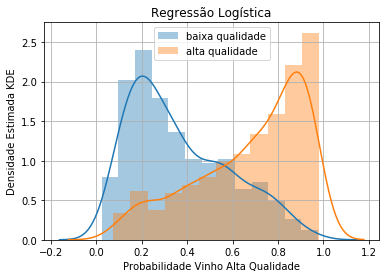

In [7]:
for i in range(len(classes)):
    # 2 Classes case
    sns.distplot(Yhat[Y[:,0] == i], label=classes[i])

plt.title('Regressão Logística')
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Vinho Alta Qualidade')
plt.grid()
plt.legend()

# Curvas ROC 

Text(0, 0.5, 'Taxa de Detecção')

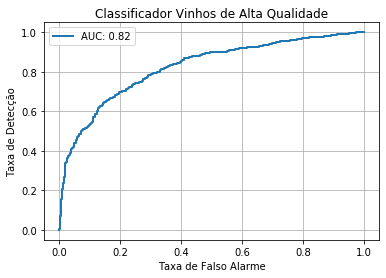

In [8]:
# help(metrics.roc_curve)
plt.figure()
fpr, tpr, thr = metrics.roc_curve(Y, Yhat)
auc = metrics.roc_auc_score(Y, Yhat)
plt.plot(fpr, tpr, '-', lw=2, label='AUC: %.2f'%(auc))
plt.legend()
plt.title('Classificador Vinhos de Alta Qualidade')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

## Matriz de Confusão 

In [9]:
col_names = ['Model ' + s for s in classes]
idx_names = ['Real ' + s for s in classes]

cmat = metrics.confusion_matrix(Y, Ypred)
cmat = pandas.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Model Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat

,Model baixa qualidade,Model alta qualidade,Real Total
Real baixa qualidade,534,210,744
Real alta qualidade,200,655,855
Model Total,734,865,1599


## Classification Report 

In [10]:
print(metrics.classification_report(Y, Ypred, target_names=classes))

                 precision    recall  f1-score   support

baixa qualidade       0.73      0.72      0.72       744
 alta qualidade       0.76      0.77      0.76       855

      micro avg       0.74      0.74      0.74      1599
      macro avg       0.74      0.74      0.74      1599
   weighted avg       0.74      0.74      0.74      1599



## Calibration Plot 

C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\BZ241WX\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. S

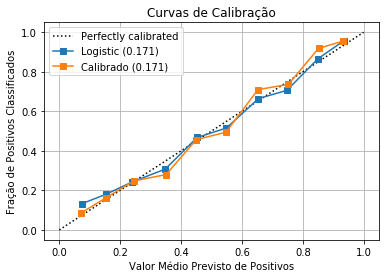

In [11]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Calibrated with sigmoid calibration
calib_sigmoid = CalibratedClassifierCV(model_pipe, cv=None, method='sigmoid')
calib_sigmoid.fit(X,Y)
Ypred_calib = calib_sigmoid.predict(X)
Yhat_calib  = calib_sigmoid.predict_proba(X)[:,1]


# Modelo perfeito
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Modelo logistico puro
clf_score = metrics.brier_score_loss(Y, Yhat, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Y, Yhat, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic (%1.3f)" %clf_score)

# Modelo calibrado
clf_score = metrics.brier_score_loss(Y, Yhat_calib, pos_label=1)
fraction_of_positives, mean_predicted_value = calibration_curve(Y, Yhat_calib, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Calibrado (%1.3f)" %clf_score)


plt.ylabel("Fração de Positivos Classificados")
plt.xlabel("Valor Médio Previsto de Positivos")
plt.ylim([-0.05, 1.05])
plt.title('Curvas de Calibração')
plt.legend()
plt.grid()